If you wanted to invest on CaC40, what should be your strategy? Should you invest on the benchmark index or rather selecting a couple of companies from the index? 

It is always difficult to build a diversified portfolio that beat the benchmark index. In the literature, the theory named "Enhanced Indexing" is meant to address this problem. In this paper, we present an alternative to traditional methods using topological data analysis (TDA). More precisely, we study the CaC40 index and build two portfolios that beat this benchmark index according to the profile risk appetite. 
# Loading the libraries   

In [61]:
import pandas_datareader as pdr
import datetime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from yahoo_fin import stock_info as si 

/Users/miradain/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


#  Loading the data from Yahoo Finance

- Extracting  data function  

In [62]:
def get(tickers, startdate, enddate):
  def data(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map (data, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

- The 30 most important stocks in the CaC40 index

In [58]:
tickers=['SGO.PA','RI.PA',  'LR.PA', 'EN.PA', 'AI.PA', 'HO.PA','ML.PA','VIV.PA','AIR.PA','ACA.PA','ENGI.PA',
        'ATO.PA','BN.PA','SW.PA','VIE.PA','BNP.PA','SAN.PA','UG.PA','KER.PA','MC.PA','ORA.PA','GLE.PA','SU.PA','DG.PA',
        'OR.PA','CA.PA','CAP.PA','AC.PA','FP.PA', 'TEP.PA']

- Extracting the stock data from Yahoo Finance

In [63]:
# Get the stock data
data = get(tickers, datetime.datetime(2005, 1, 1), datetime.datetime(2020, 6, 30))
# Isolate the `Adj Close` values and transform the DataFrame
portfolio = data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

- Extracting the CaC40 index data from Yahoo Finance

In [64]:
ticker_cac40= ['^FCHI']
portfolio_I = get(ticker_cac40, datetime.datetime(2005, 1, 1), datetime.datetime(2020, 6, 30))
index_I = portfolio_I[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

- Computing the (log) returns in the portfolio including the benchmark index

In [66]:
def asset_log_returns(index, portfolio):
    New_portfolio= portfolio
    New_portfolio[index]=index_I[index]
    asset_returns= np.log(1 + New_portfolio.pct_change()).dropna()
    return asset_returns

asset_returns= asset_log_returns('^FCHI', portfolio)

/Users/miradain/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


#  Topological data analysis (TDA)

Topological data analysis is a method invented to analyze data with a strong emphasis on its shape. This theory has sometimes been shown to be more robust than traditional methods and in some contexts it is used in combination with statistical data analysis methods. In addition, it offers excellent visualization tools for larger dimension data points. 

Topological data analysis studies the shape of the data from its point cloud (see the plot below). 

$$ 	\adjustimage{max size={0.9\linewidth}{0.9\paperheight}}{TDA_pipeline.jpg} $$


Namely, from a point cloud data, we build a filtration by thickening the points to balls with larger and larger radius. As the radius of balls encreases, circles are created and then filled out. We records the date of birth and death of each ones. This is the topological information, also called "Persistent diagram" that we will next try to search the meaning. However this valuable information is not yet appropriate for a Data Science job. We have to construct a real data feature out of persistent diagram. This process is called "Vectorization".
One way of vectorizing persistent diagrams (as shown in the plot, bottom right) consists of gluing together isosceles right triangles built on each features. This is called "Persistent Landscape".

In general topological data analysis has the following pipeline:

$$ \{ \text{Point cloud data }\} \Longrightarrow  \{ \text{Persistent Diagrams }\}  \Longrightarrow  \{ \text{Vectorization }\}  \Longrightarrow  \{ \text{ Data Science }\}$$



#  Implementation of TDA in finance

In finance, TDA has a longer pipeline:

$$ \{ \text{Data processing }\} \Longrightarrow  \{ \text{Persistent Diagrams }\}  \Longrightarrow  \{ \text{Vectorization }\}  \Longrightarrow  \{ \text{ Portfolio constructions}\}$$

We will now briefly explain each step.

- Data processing = Taken's embedding.

Financial stock data are essentially one dimensional ( time series ) data. Thus we don't have yet a point cloud for TDA analysis. We will use the Taken's embedding theorem to transform the stock data into a point cloud in $\mathbb{R}^{d}$ for some integer $d;$

- Persistent Diagrams = Use python's TDA library. 

We will use the TDA-python library "Ripser" to compute the persistent diagram.

- Vectorization = Persistent landscape + $L^p$ norm series.

Normally a single point cloud data produces a single persistent diagram and then a single persistent landscape. We will use the sliding window technic to get a series of persistent landscapes.
Moreover, knowing that the persistent landscapes form a subset of the banach space $L^p(\mathbb{N} \times \mathbb{R}),$ we can compute the $L^p$ norm for each persistent landscape. Therefore we get a series of norm values which is now the topological feature to consider for data analysis. 

- Financial analysis =  Use the topological feature to analyze the stocks  and build portfolios.

Roughly speaking we will only keep assets having highest or lowest $L^p$ norm.


In [71]:
# Loading the library for topological data analysis
import numpy as np
from ripser import ripser
from persim import plot_diagrams

The functions that we will define in this part will have the following arguments:
    
ts_data = time serie data;

p = the level of the norm $L^{p}$;

d1 = sliding window width;

d = the dimension of the embedding space;

tho = the speed of the sliding windows: the number of days to skip between windows;

resolution = resolution in the approximation of persistent landscape;

x_max = the upper bound of the intervall defining the steps;

x_min = the lower bound of the intervall defining the steps;

nb_landscapes = The number of persistent landscapes to consider. 


### Data processing

- Creation of point cloud data

In [72]:
def takenEmbedding(ts_data,d1,d=3, tho=1):
    array= np.array(ts_data)
    dic={}
    if d1-(d-1)*tho < 0:
        raise ValueError("the time serie len is too small")
    else:
        for i in range(d):
            dic[str(i)]= array[i*tho: d1-(d-1)*tho+i*tho]
    df=pd.DataFrame(dic)
    return df

###  Vectorization

- The persistence landscape function

In [73]:
def landscapes_approx(Persistent_diagram,x_min,x_max,resolution,nb_landscapes):
    landscape = np.zeros((nb_landscapes,nb_steps))
    step = (x_max - x_min) / resolution
    #Warning: naive and not the best way to proceed!!!!!
    for i in range(nb_steps):
        x = x_min + i * step
        event_list = []
        for pair in Persistent_diagram:
            b = pair[0]
            d = pair[1]
            if (b <= x) and (x<= d):
                if x >= (d+b)/2. :
                    event_list.append((d-x))
                else:
                    event_list.append((x-b))
        event_list.sort(reverse=True)
        event_list = np.asarray(event_list)
        for j in range(nb_landscapes):
            if(j<len(event_list)):
                landscape[j,i]=event_list[j]
    return landscape


- The $L^p$ norm series function

In [74]:
# The Lp-norm serie function of a given asset
def lp_norm_series(ts_data,p=2,d1=20,d=3, tho=1, resolution=1000, x_max = 0.1):
  
    # The Lp norm function for a single persistent landscape
    def lp_norm(landscape,p):
        eta= landscape**p
        norm= np.sum(eta)
        return norm
    
    N= len(ts_data)
    norm_series={'H0': np.zeros(N-d1), 'H1': np.zeros(N-d1)}
    for k in range(N):
        if N-k>d1:
            data=takenEmbedding(ts_data[k:],d1,d, tho=1)
            diagrams = ripser(data)['dgms']
            landscape0= landscapes_approx(diagrams[0],0,x_max,resolution,len(diagrams[0]))
            landscape1= landscapes_approx(diagrams[1],0,x_max,resolution,len(diagrams[1]))
            norm_series['H0'][k]=lp_norm(landscape0,p)
            norm_series['H1'][k]=lp_norm(landscape1,p)
    return norm_series


# The Lp-norm serie function for the whole portfolio 'Bin'. Note that dim='H0' or 'H1'
def norm_data(data, dim, Bin,p=2, d1=20,d=3, tho=1, resolution=1000, x_max = 0.1):
    norm_data= {}
    for i in range(len(Bin)):
        ts_data=data[Bin[i]]
        norm_data[Bin[i]]=lp_norm_series(ts_data, p)[dim]
    return norm_data

### Portfolio constructions 

We classify assets by their norm values (more precisely, the difference between their last norm values and their norm mean values). We will next split the original portfolio into three sub-portfolios: a portfolio which contains the assets with highest norm values, a portfolio of assets with lowest norm values and finally and intermediate portfolio with the rest of assets.


- The TDA enhanced indexing function (TDA_EI)

In [75]:

def TDA_EI(asset_returns, tickers, dim,p=2, d1=20, d=3, tho=1):
    diff_value= {}
    for asset in tickers:
        # Get the data of this asset
        ts_data=asset_returns[asset]
        # Compute the norm series of this asset
        norm=lp_norm_series(ts_data, p, d1, d, tho)[dim]
        # Find the difference between the last norm value and mean norm value
        diff_value[asset]= norm[-1]-np.mean(norm)
    # Sort the diff values of each assets in ascending order
    sorted_diff_value= sorted(diff_value.items(), key= lambda kv:kv[1] )
    N=len(sorted_diff_value)
    # Devide the asset class in three categories: bin1, bin2 and 'bin3'
    bin1=[v[0] for v in sorted_diff_value[:round(N/3)]]
    bin2=[v[0] for v in sorted_diff_value[round(N/3):round(2*N/3)]]
    bin3=[v[0] for v in sorted_diff_value[round(2*N/3): N]]
    return {'bin1': bin1, 'bin2': bin2, 'bin3': bin3}



- Splitting the original portfolio into sub-portfolios 

In [76]:
bins= TDA_EI(asset_returns, tickers, 'H1', 3, d1=20, d=3, tho=1)
print(bins)

{'bin1': ['GLE.PA', 'ML.PA', 'ENGI.PA', 'TEP.PA', 'EN.PA', 'BNP.PA', 'VIE.PA', 'CA.PA', 'KER.PA', 'SU.PA'], 'bin2': ['MC.PA', 'VIV.PA', 'FP.PA', 'DG.PA', 'LR.PA', 'BN.PA', 'OR.PA', 'CAP.PA', 'AI.PA', 'SAN.PA'], 'bin3': ['RI.PA', 'ATO.PA', 'ORA.PA', 'AIR.PA', 'AC.PA', 'UG.PA', 'SW.PA', 'SGO.PA', 'ACA.PA', 'HO.PA']}


#  Financial analysis of TDA portfolios

In the rest of this paper, we will compare the risk and portfolio's return of bin1 and bin3 and ignore bin2 which can be seen as an intermediate portfolio.

We will see that

- bin1 is  suitable for people with high-risk profile
- bin3 is suitable for people with low-risk profile

##  Risk analysis

###  Computing the risk (CVaR) of stocks per portfolio

In [77]:
from scipy.stats import norm

# The conditional value at risk (CVaR) function of a single asset
def CVar(asset_return, conf=0.95):
    loss= -asset_return
    # Compute the mean and the variance of the portfolio
    pm=loss.mean()
    ps=loss.std()
    # Compute the conf% VaR using .ppf()
    VaR_conf = norm.ppf(conf, loc = pm, scale = ps)
    # Compute the expected tail loss and the CVaR in the worst 5% of cases
    tail_loss = norm.expect(lambda x: x, loc = pm, scale = ps, lb = VaR_conf )
    CVar_conf = (1 / (1 - conf)) * tail_loss
    return CVar_conf

# The conditional value at risk (CVaR) function of a portfolio
def CVar_portfolio(tickers, asset_returns, conf=0.95):
    CVar_portfolio={}
    for asset in tickers:
        asset_return= asset_returns[asset]
        CVar_portfolio[asset]=CVar(asset_return, conf)
    return CVar_portfolio

# Computing the conditional values at risk (CVaR) of the different assets in each portfolio      
CVar_Bin1= CVar_portfolio(bins['bin1'], asset_returns) 
CVar_Bin2= CVar_portfolio(bins['bin2'], asset_returns) 
CVar_Bin3= CVar_portfolio(bins['bin3'], asset_returns) 

###  Representation of CVaR of assets per sub-portfolios

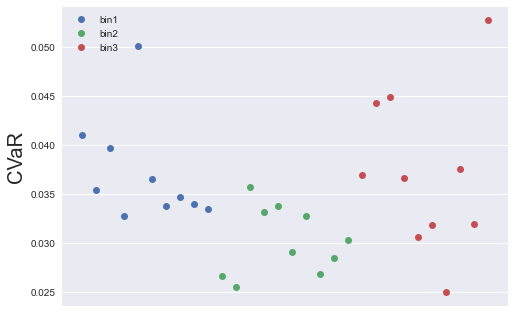

In [90]:
lists1 = sorted(CVar_Bin1.items()) # sorted by key, return a list of tuples
x1, y1 = zip(*lists1)


lists2 = sorted(CVar_Bin2.items()) # sorted by key, return a list of tuples
x2, y2 = zip(*lists2)

lists3 = sorted(CVar_Bin3.items()) # sorted by key, return a list of tuples
x3, y3 = zip(*lists3)

plt.style.use('seaborn')
plt.plot(x1, y1, 'o', label='bin1')
plt.plot(x2, y2, 'o', label='bin2')
plt.plot(x3, y3, 'o', label='bin3')
plt.legend(loc='best')
plt.ylabel('CVaR', fontsize=20) 
plt.xticks([])
plt.show()

###  Computing the risk mean per sub-portfolios

In [92]:
from numpy import array
CVar_risk1=array([CVar_Bin1[k] for k in CVar_Bin1]).mean()
CVar_risk2=array([CVar_Bin2[k] for k in CVar_Bin2]).mean()
CVar_risk3=array([CVar_Bin3[k] for k in CVar_Bin3]).mean()
print('CVaR mean of bin1:',CVar_risk1)
print('CVaR mean of bin2:',CVar_risk2)
print('CVaR mean of bin3:',CVar_risk3)

CVaR mean of bin1: 0.037135837048476866
CVaR mean of bin2: 0.030226966973985865
CVaR mean of bin3: 0.03723000647791284


We deduce from this risk analysis that even if bin1 tends to have lower risk mean than bin3, the plot shows that the CVaR in bin1 is relatively high (for all its assets) while the dispersion of risk values in bin3 is higher. In other words, it is less risky to invest on bin3 than investing on bin1.  

## Portfolio optimization
In this part, we compute the portfolio weights in bin1 and bin3. Then we compute the expected return of these sub-portfolios. 



###  Building portfolio weight

The goal is to solve the optimization problem ( see [3] for a complete description )

$$ \underset{w}{min} \underset{t=1}{\overset{d_1 -20}{\Sigma}}  \underset{t=1}{\overset{n}{\Sigma}} |N_{it}w_i-N_t|$$
subject to $$\underset{i=1}{\overset{n}{\Sigma}}\mu_i w_i -\mu_I \geq r^*$$,
$$ \underset{i=1}{\overset{n}{\Sigma}}w_i =1,$$

$$w_i \geq 0, i=1,..., n$$

where 
- $N_t:$ the TDA-norm of the benchmark index
- $N_{it}:$ the TDA-norm of the benchmark asset $i, i=1,..., n$
- $\mu_I:$ the expected return from the benchmark index
- $\mu_i= \frac{1}{d_1} \Sigma_{t=1}^{d_1} x_{it}:$ the expected return from the benchmark asset $i$ in the $d_1$ days of the sample period
- $r^{*}$ is the desired return over the above benchmark return from the portfolio

In [80]:
# Optimisation: optimal weight function
def optimal_weight(Bin, asset_returns,index, dim, p=2,r=0.02):
    Bin=Bin
    mu_assets= np.array(asset_returns[Bin].mean())
    mu_index = np.array(asset_returns[index].mean())
    Norm_data= norm_data(asset_returns[Bin], dim, Bin)
    N= lp_norm_series(asset_returns[index], p)[dim] 
    
    # Definition of constraints
    def constraint1(w):
        return mu_assets.dot(w)-mu_index-r
    def constraint2(w):
        return np.sum(w)-1
    con1= {'type': 'ineq', 'fun':constraint1}
    con2= {'type': 'eq', 'fun':constraint2}
    cons= [con1, con2]
    
    # definition of bounds
    zeros= np.zeros(len(Bin))
    ones= np.ones(len(Bin))
    bounds = Bounds(zeros.tolist(), ones.tolist())
    
    # Objective function for optimisation
    def ETDA_func(w):
        part=0
        for i in range(len(Bin)):
            norm=Norm_data[Bin[i]]
            part+= np.sum(np.abs(norm*w[i]-N))
        return part
    
    # Optimisation
    w0=np.ones(len(Bin))
    sol= minimize(ETDA_func, w0, method='SLSQP', bounds=bounds, constraints= cons)
    
    return sol.x

In [85]:
# We assume in this paper that r=0
weight_bin1=optimal_weight(bins['bin1'], asset_returns,'^FCHI', 'H1',3,0)
weight_bin3=optimal_weight(bins['bin3'], asset_returns,'^FCHI', 'H1',3,0)

In [91]:
print('weight for bin1:', weight_bin1)
print('weight for bin3:', weight_bin3)

weight for bin1: [4.04002103e-05 3.64094537e-04 2.65729927e-03 8.56415312e-04
 1.12546878e-03 1.06023060e-04 2.99057950e-03 2.12413177e-03
 9.54150575e-01 3.55850126e-02]
weight for bin3: [9.90907663e-01 6.24142404e-04 1.60937350e-03 1.72645434e-04
 8.20194429e-04 1.24489715e-05 3.87459882e-03 7.90584201e-04
 3.65140800e-05 1.15183497e-03]


###  Building portfolio returns

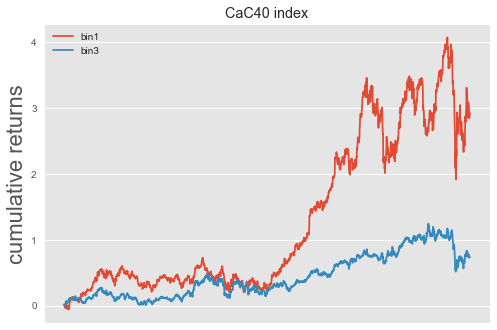

In [88]:
# Portfolio return
return_bin1=asset_returns[bins['bin1']].dot(weight_bin1)
return_bin3=asset_returns[bins['bin3']].dot(weight_bin3)

# Cumulative portfolio returns
cumulative_ret_bin1 = ((return_bin1+1).cumprod()-1)
cumulative_ret_bin3 = ((return_bin3+1).cumprod()-1)

# Plotting cumulative returns
plt.style.use('ggplot')
plt.plot(np.array(cumulative_ret_bin1), label='bin1')
plt.plot(np.array(cumulative_ret_bin3), label='bin3')
plt.ylabel('cumulative returns', fontsize=22) 
plt.title('CaC40 index')
plt.xticks([])
plt.legend()
plt.show()

It appears that portfolio bin1 has higher return than portfolio bin2.

# Comparing TDA portfolios with the CaC40 index

The question to be ask after our TDA analysis is the following: Did we finally beat the CaC40 index with our approach?

To answer to this question, we will represent on a single plot the cummulative returns of the three portfolios: bin1, bin3 and the CaC40 index.

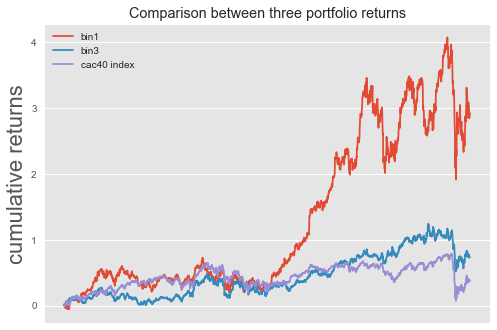

In [87]:
cumulative_ret_index=((asset_returns['^FCHI']+1).cumprod()-1)

# Plotting cumulative returns
plt.style.use('ggplot')
plt.plot(np.array(cumulative_ret_bin1), label='bin1')
plt.plot(np.array(cumulative_ret_bin3), label='bin3')
plt.plot(np.array(cumulative_ret_index), label='cac40 index')
plt.ylabel('cumulative returns', fontsize=22) 
plt.title('Comparison between three portfolio returns' )
plt.xticks([])
plt.legend()
plt.show()

This plot above shows that the portfolios bin1 and bin3 beat the benchmark index by generating higher profit.



# Conclusion

In this report, we used topological methods to propose an investment strategy on the CaC40 index.
We have extracted from the CaC40 index two sub-portfolios which have better returns than the underlying benchmark index. More precisely, instead of investing on the whole CaC40 index, we would recommend the following investment strategy according to you risk appetite:

- If your have a high-risk profile, then you should invest (under the above sugested proportions) on bin1: 
Société Générale,  Michelin, Engie, Teleperformance, Bouygues, BNP Paribas, Veolia Environ, Carrefour, Kering, and finally Schneider Electric. 

As shown in this analysis, the risk is relatively high on this portfolio but the return is be much higher than that of other portfolios including the benchmark index.


- If you have a low-risk profile, then you should invest (under the above sugested proportions) on bin3:
Pernod Ricard, Atos, Orange, Airbus, Accor, Peugeot, Sodexo, Saint-Gobain, Crédit Agricole and finally Thales.

This latter portfolio is less risky than bin1. The return is not that high but it is still benefict to invest on this one than the benchmark index.

Note that our recommendations do not take into account the current situation and a wise investor should also track the financial (S1,S2 and annual) reports of these companies.

# Declaration of Competing Interest
The author declares that he has no known competing financial interests or personal relationships that could have appeared to influence the work reported in this tutorial.

# Perspectives
What else can we do after this investigation?

- It is possible to compare the performance of this method with the traditional enhanced indexing methods such as Excess Mean Return. A study in this direction was done in [3];

- This approach can be used on other stock indexes and any existing portfolio. If you are a portfolio manager, then you can empirically compare our approach with your own strategy and then broaden you management tools.

- If you think the returns we got in this analysis were not high enough, then you can tun the meta parameters such as d (taken embedding dimension) and p (for the $L^p$ norm) and all others. By this process, you could increase the profit.   

# References

[1] Peter Bubenik. Statistical topological data analysis using persistence land- scapes. The Journal of Machine Learning Research, 16(1):77–102, 2015.

[2] Marian Gidea and Yuri Katz. Topological data analysis of financial time series: Landscapes of crashes. Physica A: Statistical Mechanics and its Ap- plications, 491:820–834, 2018.

[3] Anubha Goel, Puneet Pasricha, and Aparna Mehra. Topological data analysis in investment decisions. Expert Systems with Applications, 147:113222, 2020.